### Packages

In [232]:
import torch# If there's a GPU available...
import random
import numpy as np
import multiprocessing
import pandas as pd
import time

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" ##I will find a way to fix this later :(

NUM_GPUS=0

try:
    if torch.cuda.is_available():  
        device = torch.device("cuda")
        NUM_GPUS=torch.cuda.device_count()
        print('There are %d GPU(s) available.' % NUM_GPUS)
        print('We will use the GPU:', torch.cuda.get_device_name())# If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")  
except:
    print('Cuda error using CPU instead.')
    device = torch.device("cpu")  
    
print(device)

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

There are 2 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
cuda
Cpu count:  24


#### Specify Directories

In [233]:
from ipynb.fs.full.Dataset import getDataset, getDummyDataset, getRandomDataset, Data        

DIR='./Results'
    
from pathlib import Path
Path(DIR).mkdir(parents=True, exist_ok=True)

DATASET_LOAD_DIR="./NVD/"
MODEL_SAVE_DIR=DIR+'/NVD/Model/'

Path(MODEL_SAVE_DIR).mkdir(parents=True, exist_ok=True)
print("Data loading directory: ", DIR)
print("Model Saving directory:", MODEL_SAVE_DIR)

Data loading directory:  ./Results
Model Saving directory: ./Results/NVD/Model/


### Some more packages

In [234]:
import pandas as pd
import pathlib
import zipfile
import wget

import torch
from torch import nn
from torch import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import RandomSampler,SequentialSampler
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, CosineEmbeddingLoss

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, AutoModelWithLMHead
from transformers import AutoModelForMaskedLM
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers.models.roberta.modeling_roberta import RobertaLMHead
from transformers import AutoConfig

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForLanguageModeling

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.tuner.tuning import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.trainer.supporters import CombinedLoader

#### For reproduciblity

In [235]:
# Set the seed value all over the place to make this reproducible.
from random import sample

seed_val = 42
os.environ['PYTHONHASHSEED'] = str(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
pl.seed_everything(seed_val)

try:
    torch.cuda.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except:
    print("nothing to set for cudnn")

Global seed set to 42


### Data class definition

#### Accuracy precision level

In [236]:
K_NEG_LINKS=None
TOP_K0=[1,3,5]
TOP_K1=[1,2,2]
TOP_K2=[1,1,2]

In [237]:
def log_results(filename,infos,append=True):    
    f=None
    if append==True:  
        f=open(filename, 'a+')
    else:
        f=open(filename, 'w')
    
    f.write("\n")    
    for key, values in infos.items():
        f.write("%s :" % key)
        if type(values).__name__=='list':            
            for item in values:
                f.write("%s " % item)
        else:
            f.write("%s " % values)           
        f.write("\n")
    
    f.close()
#log_results("testing",{'train_acc':[1,2,3,4]})
#log_results("testing",{'train_acc':1})

#### CVE Dataset

In [238]:
class CDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, org_labels, collator, data, k_neg_link=10, use_collator=True):
        self.encodings = encodings
        self.labels = labels
        self.org_labels = org_labels
        self.collator = collator
        self.data = data
        self.k_neg_link=k_neg_link
        self.use_collator=use_collator

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}            
        if self.use_collator:
            item = self.collator([item])
            item = {key: val[0] for key, val in item.items()}
        item['h_labels']= self.labels[idx]
        item['o_labels']= self.org_labels[idx]
        
        POS=[]
        NEG=[]
        
        #------POSITIVE LINKS-----
        p_labels=(self.labels[idx]==1).nonzero().flatten()        
        for c in p_labels: POS.append(c.item())
        
        #------NEG LINKS-----
        n_labels=(self.labels[idx]==0).nonzero().flatten()    
        limit=min(len(n_labels),self.k_neg_link)
        indexs=np.random.choice(len(n_labels),limit, replace=False)
        n_labels=n_labels[indexs]            
        for c in n_labels: NEG.append(c.item())
        
        NEG=(NEG*int(self.k_neg_link/len(NEG)+1))[:self.k_neg_link]
        POS=(POS*int(self.k_neg_link/len(POS)+1))[:self.k_neg_link]
        
        item['pos']=torch.tensor(POS, dtype=torch.long)
        item['neg']=torch.tensor(NEG, dtype=torch.long)
        
        item['pos_label']=torch.ones(len(POS), dtype=torch.long)
        item['neg_label']=torch.zeros(len(NEG), dtype=torch.long)
             
        return item

    def __len__(self):
        return len(self.labels)

#### Testing CVE dataset
```
A=AutoTokenizer
berttokenizer=A.from_pretrained('bert-base-uncased')
datacollator=DataCollatorForLanguageModeling(tokenizer=berttokenizer,mlm_probability=0.15, mlm=True)

data, sentences, labels = getDummyDataset()
if type(labels)!=torch.Tensor:
    labels=torch.tensor(labels,dtype=torch.long)
else:
    labels=labels.type(torch.LongTensor)
    
train_encodings = berttokenizer(sentences, truncation=True, padding=True)
dataset = CDataset(train_encodings, labels, labels, datacollator, data)

dataset[1]
```

#### CWE Dataset

In [239]:
class DDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, org_labels, collator, data, use_collator=True):
        self.encodings = encodings
        self.labels = labels
        self.org_labels = org_labels
        self.collator = collator
        self.data = data
        self.use_collator=use_collator

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}            
        if self.use_collator:
            item = self.collator([item])
            item = {key: val[0] for key, val in item.items()}
        item['h_labels']= self.labels[idx]
        item['o_labels']= self.org_labels[idx]
        
        return item

    def __len__(self):
        return len(self.labels)

#### Testing CWE Dataset
```
A=AutoTokenizer
berttokenizer=A.from_pretrained('bert-base-uncased')
datacollator=DataCollatorForLanguageModeling(tokenizer=berttokenizer,mlm_probability=0.15, mlm=True)

data, sentences, labels = getDummyDataset()
if type(labels)!=torch.Tensor:
    labels=torch.tensor(labels,dtype=torch.long)
else:
    labels=labels.type(torch.LongTensor)
    
    
class_mask=(data.class_mask == True).nonzero().flatten().numpy()
class_encodings = berttokenizer([sentences[i] for i in class_mask], truncation=True, padding=True)

dataset = CDataset(class_encodings, labels, labels, datacollator, data)

dataset[3]
```

In [240]:
class DataProcessing(pl.LightningDataModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        #self.save_hyperparameters()
        if isinstance(args, tuple): args = args[0]
        self.hparams = args
        self.batch_size=self.hparams.batch_size        

        print(f'PRETRAINED:{self.hparams.pretrained}')

        A = AutoTokenizer
        self.tokenizer = A.from_pretrained(self.hparams.pretrained, use_fast=True)
        print('Tokenizer:', type(self.tokenizer))
        
        self.datacollator=DataCollatorForLanguageModeling(tokenizer=self.tokenizer, mlm_probability=0.15)
    
    
    def get_cwe_level(self):
        self.levels={}
        for key,values in self.data.depth.items():
            if type(values)==int:
                values=[values]

            for val in values:
                if val in self.levels:
                    if(key not in self.levels[val]):self.levels[val].append(key)
                else:
                    self.levels[val]=[key]

#         for i,j in self.levels.items():
#             print(i,"->",len(j),':',j)
            
    
    def indexsToUpdate(self,parentid,indexs):
        if parentid==-1:
            return

        if(parentid not in indexs):
            indexs.append(parentid)

        parents=self.data.child_parent[parentid]

        for parent in parents:
                self.indexsToUpdate(parent,indexs)

        return
    
    def updates_label_by_hierarchy(self,labels):
        all_mask=self.data.train_mask|self.data.val_mask|self.data.test_mask|self.data.class_mask
        labeled_indexs= (all_mask == True).nonzero().flatten().numpy()

        for i in labeled_indexs:    
            row_labels=(labels[i]==1).nonzero().flatten().numpy()    

            #print(row_labels,"->",end='')

            indexs=[]
            for r_label in row_labels:
                parents=self.data.child_parent[r_label]

                for parent in parents:
                    self.indexsToUpdate(parent,indexs)

            #print(indexs)

            labels[i][indexs]=1

        return labels
               
        
    def setup(self, stage=None):
        MAX_TEXT_LENGTH=512
    
#         CVE dataset
#         ------------------------------------        
        data, df_CVE, df_CWE=None,None,None
    
        if self.hparams.rand_dataset=='dummy':            
            #------------------------------------
            data, sentences, labels = getDummyDataset()        
            #------------------------------------
        else:        
            if self.hparams.rand_dataset=='temporal':
                print("Temporal Partition:--")
                data, df_CVE, df_CWE = getDataset(DATASET_LOAD_DIR)            
            else:
                print("Random Partition:--")
                data, df_CVE, df_CWE = getRandomDataset(DATASET_LOAD_DIR, 0.70, 0.10)

            sentences=df_CVE['CVE Description'].apply(lambda x: x[:MAX_TEXT_LENGTH])
            labels=data.y
            CWE_IDS_USED=df_CWE['Name'].tolist()
            INDEX_TO_CWE_MAP=dict(zip(list(range(len(CWE_IDS_USED))),CWE_IDS_USED))
            CWE_TO_INDEX_MAP=dict(zip(CWE_IDS_USED,list(range(len(CWE_IDS_USED)))))
            sentences=sentences.tolist()
        
#         #------------------------------------        
#         #CVE dummy dataset
#         #------------------------------------
#         data, sentences, labels = getDummyDataset()        
#         #------------------------------------

        
        
        if type(labels)!=torch.Tensor:
            labels=torch.tensor(labels,dtype=torch.long)
        else:
            labels=labels.type(torch.LongTensor)
        self.data=data        
        org_labels=np.copy(labels) ###keep the copy of orgiginal labels
        
        self.get_cwe_level()        
        labels=self.updates_label_by_hierarchy(labels)

        
        self.NUM_CLASSES=len(data.y[0])
        
        train_mask= (data.train_mask == True).nonzero().flatten().numpy()
        val_mask= (data.val_mask == True).nonzero().flatten().numpy()
        test_mask= (data.test_mask == True).nonzero().flatten().numpy()
        class_mask=(data.class_mask == True).nonzero().flatten().numpy()
        
        print("Train size:", len(train_mask))
        print("Val size:", len(val_mask))
        print("Test size:", len(test_mask))
        print("Class size:",len(class_mask))

        
        train_encodings = self.tokenizer([sentences[i] for i in train_mask], truncation=True, padding=True, max_length=MAX_TEXT_LENGTH)        
        
        self.dataset = CDataset(
            train_encodings, 
            labels[data.train_mask], 
            org_labels[data.train_mask],
            self.datacollator,
            data,
            K_NEG_LINKS
        )
        self.datasetNC = CDataset(
            train_encodings, 
            labels[data.train_mask], 
            org_labels[data.train_mask],
            self.datacollator,
            data,
            K_NEG_LINKS,
            use_collator=False
        )        
                
        val_encodings = self.tokenizer([sentences[i] for i in val_mask], truncation=True, padding=True, max_length=MAX_TEXT_LENGTH)
        self.val_dataset=CDataset(
            val_encodings, 
            labels[data.val_mask],
            org_labels[data.val_mask],
            self.datacollator,
            data,
            K_NEG_LINKS
        )
        self.val_datasetNC=CDataset(
            val_encodings, 
            labels[data.val_mask],
            org_labels[data.val_mask],
            self.datacollator,
            data,
            K_NEG_LINKS,
            use_collator=False
        )
        
        test_encodings = self.tokenizer([sentences[i] for i in test_mask], truncation=True, padding=True, max_length=MAX_TEXT_LENGTH)
        self.test_dataset=CDataset(
            test_encodings,
            labels[data.test_mask],
            org_labels[data.test_mask],
            self.datacollator,
            data,
            K_NEG_LINKS
        )
        self.test_datasetNC=CDataset(
            test_encodings,
            labels[data.test_mask],
            org_labels[data.test_mask],
            self.datacollator,
            data,
            K_NEG_LINKS,
            use_collator=False
        )
        
        class_encodings = self.tokenizer([sentences[i] for i in class_mask], truncation=True, padding=True, max_length=MAX_TEXT_LENGTH)        
        self.class_dataset = DDataset(
            class_encodings, 
            labels[data.class_mask], 
            org_labels[data.class_mask],
            self.datacollator,
            data
        )
        self.class_datasetNC = DDataset(
            class_encodings, 
            labels[data.class_mask], 
            org_labels[data.class_mask],
            self.datacollator,
            data,
            use_collator=False
        )
    
    def class_dataloader(self, use_collator=True):
        dataset=None
        if use_collator:
            dataset=self.class_dataset
        else:
            dataset=self.class_datasetNC
            
        class_sampler = SequentialSampler(dataset)
        
        loader_cwe = DataLoader(
            dataset,
            sampler=class_sampler, 
            batch_size=len(dataset),
            pin_memory=True,
            #num_workers=min(NUM_PROCESSORS,self.batch_size, NUM_GPUS*4)
        )
        
        return loader_cwe
    
    def train_dataloader(self,use_collator=True):
        
        dataset=None
        if use_collator:
            dataset=self.dataset
        else:
            dataset=self.datasetNC
        
        train_sampler = RandomSampler(dataset)        
        loader_cve = DataLoader(
            dataset,
            sampler=train_sampler, 
            batch_size=self.batch_size,
            pin_memory=True,
            #num_workers=min(NUM_PROCESSORS,self.batch_size,NUM_GPUS*4)
        )
        
        return loader_cve
    
    def val_dataloader(self, use_collator=True):
        dataset=None
        
        if use_collator:
            dataset=self.val_dataset
        else:
            dataset=self.val_datasetNC
    
        val_sampler = SequentialSampler(dataset)
        
        loader_cve=DataLoader(
            dataset,
            sampler=val_sampler, 
            batch_size=self.batch_size,
            pin_memory=True,
            #num_workers=min(NUM_PROCESSORS,self.batch_size,NUM_GPUS*4)
        )
        
        return loader_cve
    
    def test_dataloader(self,use_collator=True):
        dataset=None        
        if use_collator:
            dataset=self.test_dataset
        else:
            dataset=self.test_datasetNC

        test_sampler = SequentialSampler(dataset)        
        loader_cve=DataLoader(
            dataset,
            sampler=test_sampler, 
            batch_size=self.batch_size,
            pin_memory=True,
            #num_workers=min(NUM_PROCESSORS,self.batch_size, NUM_GPUS*4)
        )
        
        return loader_cve


# #----------------------------
# import argparse
# from argparse import ArgumentParser

# parser = ArgumentParser()
# parser.add_argument('--pretrained', type=str, default="bert-base-uncased")
# parser.add_argument('--batch_size', type=int, default=32)
# parser.add_argument('-f') ##dummy for jupyternotebook
# parser = pl.Trainer.add_argparse_args(parser)
# args = parser.parse_args()
# dataProcessor = DataProcessing(args)
# dataProcessor.setup()
# #----------------------------

### Get Configuration to run

In [241]:
import argparse
from argparse import ArgumentParser

def get_configuration():
    parser = ArgumentParser()

    parser.add_argument('--pretrained', type=str, default="bert-base-uncased")
    #parser.add_argument('--pretrained', type=str, default="roberta-base")
    #parser.add_argument('--pretrained', type=str, default="distilbert-base-uncased")    
    parser.add_argument('--epochs', type=int, default=25)
    parser.add_argument('--nr_frozen_epochs', type=int, default=5)
    #parser.add_argument('--training_portion', type=float, default=0.9)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--auto_batch', type=int, default=-1)
    parser.add_argument('--learning_rate', type=float, default=2e-5)
    parser.add_argument('--frac', type=float, default=1)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--nodes', type=int, default=1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--refresh_rate', type=int, default=100)
    parser.add_argument('--checkpointing', type=str, default='True', choices=['True','False'])
    parser.add_argument('--use_rd', type=str, default='False', choices=['True','False'])
    parser.add_argument('--lm_lambda', type=float, default=0.1)
    parser.add_argument('--rand_dataset', type=str, default="dummy", choices=['temporal','random','dummy'])
    parser.add_argument('--use_pretrained', type=str, default='True', choices=['True','False'])
    parser.add_argument('--neg_link', type=int, default=120)
    parser.add_argument('--check', type=bool, default=False)
    parser.add_argument('--performance_mode', type=str, default='False', choices=['True','False'])
    parser.add_argument('--freeze', type=str, default='True')
    
    parser.add_argument('-f') ##dummy for jupyternotebook

    # parser = Model.add_model_specific_args(parser) parser = Data.add_model_specific_args(parser)
    parser = pl.Trainer.add_argparse_args(parser)
    args = parser.parse_args()
    
    global K_NEG_LINKS
    K_NEG_LINKS=args.neg_link    
    print("-"*50)
    print("POS/NEG Links: ",K_NEG_LINKS)
    print("BATCH SIZE: ", args.batch_size)
    
    
    # start : get training steps
    dataProcessor = DataProcessing(args)
    dataProcessor.setup()
    args.NUM_CLASSES=dataProcessor.NUM_CLASSES
    args.MODEL_NAME="CBERT-LINK-"+args.pretrained+'-'+args.parallel_mode
    args.MODEL_DIR_FILE=MODEL_SAVE_DIR+args.MODEL_NAME
    #args.PRE_TRAINED_MODEL=MODEL_SAVE_DIR+"CBERT-"+args.pretrained+'-'+args.parallel_mode+'.ckpt'
    args.PRE_TRAINED_MODEL=MODEL_SAVE_DIR+"CBERT-"+args.pretrained+'.ckpt'
    
    args.num_training_steps = len(dataProcessor.train_dataloader())*args.epochs
    dict_args = vars(args)
    
    gpus=-1
    if NUM_GPUS>0:
        gpus=args.num_gpus
    else:
        gpus=None
        args.parallel_mode=None
    
    print("USING GPUS:", gpus)
    print("-"*50)
    
    # saves a file like: my/path/sample-mnist-epoch=02-val_loss=0.32.ckpt
    checkpoint_callback = ModelCheckpoint(
        monitor='loss_epoch',
        dirpath=MODEL_SAVE_DIR,
        filename='{epoch:02d}-{loss:.4f}',
        save_top_k=1,
        mode='min',
        save_weights_only=True,
        prefix="CBERT-LINK"+args.pretrained+'-'+str(args.parallel_mode),
        save_last=True,
    )
    
    if args.check==False:
        args.checkpoint_callback = False
    elif args.parallel_mode=='dp':
        args.callbacks=[checkpoint_callback]        
    else:
        args.checkpoint_callback = False
    
    trainer = pl.Trainer.from_argparse_args(args, 
                                            gpus=gpus,
                                            num_nodes=args.nodes, 
                                            accelerator=args.parallel_mode,
                                            max_epochs=args.epochs, 
                                            gradient_clip_val=1.0,                                            
                                            logger=False,
                                            progress_bar_refresh_rate=args.refresh_rate,
                                            profiler=False, #'simple',
                                            default_root_dir=MODEL_SAVE_DIR,                                            
                                            deterministic=True,
                                           )
    
    return trainer, dataProcessor, args, dict_args

#trainer, dataProcessor, args, dict_args = get_configuration()

### Model definition

https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForMaskedLM

https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification    

https://huggingface.co/transformers/_modules/transformers/models/roberta/modeling_roberta.html#RobertaForMaskedLM

https://huggingface.co/transformers/_modules/transformers/models/distilbert/modeling_distilbert.html#DistilBertForMaskedLM

In [242]:
from transformers.activations import gelu

class BaseModelDistillBert(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters()
        self._frozen = False
        
        config = AutoConfig.from_pretrained(self.hparams.pretrained,                                            
                                            output_attentions=False,
                                            output_hidden_states=False)
        self.config=config
        
        A = AutoModel 
        self.base_model = A.from_pretrained(self.hparams.pretrained, config=config)                
                
        self.vocab_transform = nn.Linear(config.dim, config.dim)
        self.vocab_layer_norm = nn.LayerNorm(config.dim, eps=1e-12)
        self.vocab_projector = nn.Linear(config.dim, config.vocab_size)
        
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.dropout = nn.Dropout(config.seq_classif_dropout)
        
        self.CELoss = CrossEntropyLoss()

        print('Base: ', type(self.base_model))
    

    def forward(self, batch):
        
        outputs = self.base_model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )        
        
        hidden_states = outputs[0]  # (bs, seq_length, dim)
        
        masked_lm_loss=None
        if 'labels' in batch:        
            labels=batch['labels']      
            
            prediction_logits = self.vocab_transform(hidden_states)  # (bs, seq_length, dim)
            prediction_logits = gelu(prediction_logits)  # (bs, seq_length, dim)
            prediction_logits = self.vocab_layer_norm(prediction_logits)  # (bs, seq_length, dim)
            prediction_logits = self.vocab_projector(prediction_logits)  # (bs, seq_length, vocab_size)

            masked_lm_loss = self.CELoss(prediction_logits.view(-1, prediction_logits.size(-1)), labels.view(-1))
            
            del labels, prediction_logits
        
        
        pooled_output = hidden_states[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled = self.dropout(pooled_output)  # (bs, dim)

        del batch
        del outputs
        
        if masked_lm_loss is not None: 
            masked_lm_loss = masked_lm_loss.view(1)
        
        return (masked_lm_loss, pooled)
        
    
# #----------------------------
# parser = ArgumentParser()
# parser.add_argument('--pretrained', type=str, default="distilbert-base-uncased")
# parser.add_argument('--batch_size', type=int, default=32)
# parser.add_argument('-f') ##dummy for jupyternotebook
# args = parser.parse_args()
# dict_args = vars(args)
# base_model=BaseModelDistillBert(**dict_args)
# print(base_model)
# #----------------------------

In [243]:
class BaseModel(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters()
        self._frozen = False
        
        config = AutoConfig.from_pretrained(self.hparams.pretrained,                                            
                                            output_attentions=False,
                                            output_hidden_states=False)
        self.config=config
        
        A = AutoModel #AutoModelForMaskedLM, AutoModelForSequenceClassification
        self.base_model = A.from_pretrained(self.hparams.pretrained, config=config)                
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
        if self.hparams.pretrained in ['bert-base-uncased','bert-large-uncased']: 
            self.lm_cls = BertOnlyMLMHead(config)
                    
        elif self.hparams.pretrained in ['roberta-base','roberta-large']:
            self.lm_cls = RobertaLMHead(config)
                    
        print("LM: ",type(self.lm_cls))
        
        self.CELoss = CrossEntropyLoss()

        print('Base: ', type(self.base_model))
        
        print("Freezing Layers:-")
        if self.hparams.freeze=='True':                
            if self.hparams.pretrained in ['bert-base-uncased','roberta-base']:
                self.freeze('layer.9')
            elif self.hparams.pretrained in ['bert-large-uncased', 'roberta-large']:
                self.freeze('layer.21')            
            else:
                print("Nothing Frozen")
        elif self.hparams.freeze=='False':
            print("Nothing Frozen")
        
        else:
            self.freeze(self.hparams.freeze)
                        

    def forward(self, batch):
        
        outputs = self.base_model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )        
        
        masked_lm_loss=None
        if 'labels' in batch:        
            labels=batch['labels']      
            prediction_scores = self.lm_cls(outputs.last_hidden_state)            
            masked_lm_loss = self.CELoss(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))
            del labels, prediction_scores
        
        pooled=outputs.pooler_output        
        pooled=self.dropout(pooled)
        
        del batch
        del outputs
        
        if masked_lm_loss is not None: 
            masked_lm_loss = masked_lm_loss.view(1)
        
        return (masked_lm_loss, pooled)
    
    def freeze(self,layername) -> None:        
        for name, param in self.base_model.named_parameters():            
#             print(name)            
            if layername in name:
                print("Froze upto: ", name)
                break
            else:
                param.requires_grad = False
                
        self._frozen = True
        
    
# #----------------------------
# parser = ArgumentParser()
# parser.add_argument('--pretrained', type=str, default="roberta-base")
# parser.add_argument('--batch_size', type=int, default=32)
# parser.add_argument('-f') ##dummy for jupyternotebook
# args = parser.parse_args()
# dict_args = vars(args)
# base_model=BaseModel(**dict_args)
# print(base_model)
# #----------------------------

In [244]:
class LinkPredictionModel(pl.LightningModule):
    def __init__(self, config, *args, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        #self.lc_1 = nn.Linear(config.hidden_size*2,2)
        #self.lc_1 = nn.Linear(config.hidden_size,2)
        
        self.lc_1 = nn.Linear(config.hidden_size*2, config.hidden_size)
        self.lc_2 = nn.Linear(config.hidden_size,2)
        
        self.tanh=nn.Tanh()
        self.softmax=nn.Softmax(dim=1)
        self.CELoss = CrossEntropyLoss()
    
    def forward(self, CVE_vectors, CWE_vectors, true_links=None):
        logits = self.lc_1(torch.cat((torch.abs(CVE_vectors-CWE_vectors),CVE_vectors*CWE_vectors), 1))
        #logits = self.lc_1(CVE_vectors*CWE_vectors)
        logits = self.lc_2(self.tanh(logits))
        
        loss=None
        if true_links is not None:
            loss=self.CELoss(logits,true_links)     
            
        if loss is not None: 
            loss = loss.view(1)
            
        return (loss, logits)

In [245]:
class Model(pl.LightningModule):
    def __init__(self,*args, **kwargs):
        super().__init__()
        self.save_hyperparameters() 
        
        if self.hparams.pretrained == "distilbert-base-uncased":
            self.base_model=BaseModelDistillBert(*args, **kwargs)
        else:        
            self.base_model=BaseModel(*args, **kwargs)
        self.link_model=LinkPredictionModel(self.base_model.config, *args, **kwargs)
        
        if NUM_GPUS > 1: 
            ids=None
            if self.hparams.num_gpus!=-1:
                ids=list(range(self.hparams.num_gpus))
                
            self.base_model = nn.DataParallel(self.base_model, device_ids=ids)
            self.link_model = nn.DataParallel(self.link_model, device_ids=ids)
        

    def forward(self, batch, CWE_pooled):                
        lm_loss, CVE_pooled=model.base_model(batch)
        
        CVE_vectors=CVE_pooled[batch['CVE_index']]
        CWE_vectors=CWE_pooled[batch['CWE_index']]
        true_links=batch['true_labels']
    
        (loss, logits)=self.link_model(CVE_vectors,CWE_vectors, true_links)        

        del CVE_vectors, CWE_vectors, batch
        
        loss=loss.mean()
        
        if lm_loss is not None:
            loss+= ((self.hparams.lm_lambda)*lm_loss.mean())

        return (loss, logits, true_links)

        
    def configure_optimizers(self):
        
        no_decay = ['bias', 'LayerNorm.weight']

        optimizer_grouped_parameters = [{
            'params': [
                p for n, p in self.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            'weight_decay':
            0.01
        }, {
            'params': [
                p for n, p in self.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            'weight_decay':
            0.0
        }]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparams.learning_rate,
                          eps=1e-8 # args.adam_epsilon  - default is 1e-8.
                          )

        
        # We also use a scheduler that is supplied by transformers.
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0, # Default value in run_glue.py
            num_training_steps=self.hparams.num_training_steps)

        return optimizer, scheduler

In [246]:
def printModelParams(model):
    print (model)
    # Get all of the model's parameters as a list of tuples.
    params = list(model.named_parameters())
    print('The model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')
    for p in params[0:5]:
        print("{:<55} {:>12}, {}".format(p[0], str(tuple(p[1].size())),p[1].requires_grad))

    print('\n==== First Transformer ====\n')
    for p in params[5:21]:
        print("{:<55} {:>12}, {}".format(p[0], str(tuple(p[1].size())),p[1].requires_grad))

    print('\n==== Output Layer ====\n')
    for p in params[-5:]:
        print("{:<55} {:>12}, {}".format(p[0], str(tuple(p[1].size())),p[1].requires_grad))
        
def print_model_value(model):
    params = list(model.named_parameters())
    print (params[-1][0],params[-1][1][:4])

### Main
Two key aspects:

- pytorch lightning can add arguments to the parser automatically
- you can manually add your own specific arguments.

- there is a little more code than seems necessary, because of a particular argument the scheduler
  needs. There is currently an open issue on this complication
  https://github.com/PyTorchLightning/pytorch-lightning/issues/1038

### Models and Dataloaders

In [247]:
trainer, dataProcessor, args, dict_args = get_configuration()
log_results(args.MODEL_DIR_FILE+'_log.txt',dict_args,append=False)

model = Model(**dict_args)

--------------------------------------------------
POS/NEG Links:  120
BATCH SIZE:  32
PRETRAINED:bert-base-uncased


/home/das90/.conda/envs/cent7/5.3.1-py37/cs690_37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: Checkpoint directory ./Results/NVD/Model/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Tokenizer: <class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>
Train size: 8
Val size: 13
Test size: 13
Class size: 4
USING GPUS: -1
--------------------------------------------------
LM:  <class 'transformers.models.bert.modeling_bert.BertOnlyMLMHead'>
Base:  <class 'transformers.models.bert.modeling_bert.BertModel'>
Freezing Layers:-
Froze upto:  encoder.layer.9.attention.self.query.weight


In [248]:
class PretrainedModel(pl.LightningModule):
    def __init__(self,*args, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        config = AutoConfig.from_pretrained(self.hparams.pretrained,
                                            output_attentions=False,
                                            output_hidden_states=False)
        A = AutoModelForMaskedLM
        self.model = A.from_pretrained(self.hparams.pretrained, config=config)
        print('Model: ', type(self.model))

if args.use_pretrained=='True':
    print('Loading Pretrained Model: ',args.PRE_TRAINED_MODEL)    
    if os.path.exists(args.PRE_TRAINED_MODEL): 
            
        pretrainedModel=PretrainedModel(**dict_args)
        
        try:
        
            if args.pretrained in ['bert-base-uncased','bert-large-uncased']:        

                checkpoint = torch.load(args.PRE_TRAINED_MODEL, map_location=lambda storage, loc: storage)

                if NUM_GPUS>1: 
                    model_dict = (model.base_model.module.base_model).state_dict()
                    pretrained_dict = {k: v for k, v in (pretrainedModel.model.bert).state_dict().items() if k in model_dict}
                    print("Matched: ",len(pretrained_dict.keys()))
                    model_dict.update(pretrained_dict) 
                    (model.base_model.module.base_model).load_state_dict(model_dict)
                else:
                    model_dict = (model.base_model.base_model).state_dict()
                    pretrained_dict = {k: v for k, v in (pretrainedModel.model.bert).state_dict().items() if k in model_dict}
                    print("Matched: ",len(pretrained_dict.keys()))
                    model_dict.update(pretrained_dict) 
                    (model.base_model.base_model).load_state_dict(model_dict)

            elif args.pretrained in ['roberta-base','roberta-large']:

                checkpoint = torch.load(args.PRE_TRAINED_MODEL, map_location=lambda storage, loc: storage)

                if NUM_GPUS>1: 
                    model_dict = (model.base_model.module.base_model).state_dict()
                    pretrained_dict = {k: v for k, v in (pretrainedModel.model.roberta).state_dict().items() if k in model_dict}
                    print("Matched: ",len(pretrained_dict.keys()))
                    model_dict.update(pretrained_dict) 
                    (model.base_model.module.base_model).load_state_dict(model_dict)
                else:
                    model_dict = (model.base_model.base_model).state_dict()
                    pretrained_dict = {k: v for k, v in (pretrainedModel.model.roberta).state_dict().items() if k in model_dict}
                    print("Matched: ",len(pretrained_dict.keys()))
                    model_dict.update(pretrained_dict) 
                    (model.base_model.base_model).load_state_dict(model_dict)


            elif args.pretrained=='distilbert-base-uncased':

                if NUM_GPUS>1: 
                    model_dict = (model.base_model.module.base_model).state_dict()
                    pretrained_dict = {k: v for k, v in (pretrainedModel.model.distilbert).state_dict().items() if k in model_dict}
                    print("Matched: ",len(pretrained_dict.keys()))
                    model_dict.update(pretrained_dict) 
                    (model.base_model.module.base_model).load_state_dict(model_dict)
                else:
                    model_dict = (model.base_model.base_model).state_dict()
                    pretrained_dict = {k: v for k, v in (pretrainedModel.model.distilbert).state_dict().items() if k in model_dict}
                    print("Matched: ",len(pretrained_dict.keys()))
                    model_dict.update(pretrained_dict) 
                    (model.base_model.base_model).load_state_dict(model_dict)
        except:
            print("Pytorch version missmatch between saved and new model")

    else:
        print("File not found will continue with original model")
else:
    print("Use default model as base...")

Loading Pretrained Model:  ./Results/NVD/Model/CBERT-bert-base-uncased.ckpt


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model:  <class 'transformers.models.bert.modeling_bert.BertForMaskedLM'>
Matched:  198


In [249]:
print("Depolying model to ",device)
model=model.to(device)

Depolying model to  cuda


In [250]:
train_dataloader=dataProcessor.train_dataloader()    
val_dataloader=dataProcessor.val_dataloader()
test_dataloader=dataProcessor.test_dataloader()
class_dataloader=dataProcessor.class_dataloader()

train_dataloaderNC=dataProcessor.train_dataloader(use_collator=False)    
val_dataloaderNC=dataProcessor.val_dataloader(use_collator=False)
test_dataloaderNC=dataProcessor.test_dataloader(use_collator=False)
class_dataloaderNC=dataProcessor.class_dataloader(use_collator=False)

In [251]:
# iter_dataloader=iter(class_dataloaderNC)
# next(iter_dataloader)

#### Evaluation Metrices

In [252]:
from sklearn.metrics import f1_score

def th_link_acc(preds,labels,th=0.50):
    pred=(preds >= th).astype(int)    
    return np.sum(pred == labels) / len(labels)

def th_link_f1_score(logits,y_true,th=0.50):
    logits=(torch.nn.functional.softmax(logits,dim=1))[:1]
    y_pred=(logits >= th).astype(int)    
    
    return f1_score(y_true, y_pred, average='macro')

def link_f1_score(logits,y_true):
#     print(logits)
#     logits=(torch.nn.functional.softmax(logits,dim=1))
    y_pred=np.argmax(logits,axis=1)
#     print(y_pred)
#     print(y_true)
    
    return f1_score(y_true, y_pred, average='macro')
#     f1_score(y_true, y_pred, average='micro')
#     f1_score(y_true, y_pred, average='weighted')    
#     f1_score(y_true, y_pred, zero_division=1)

In [253]:
# for i,j in dataProcessor.levels.items():
#     print(i,"->",len(j),':',j)
levels=dataProcessor.levels
data=dataProcessor.data

def getHierIndexs(child, preds,k2, indexs, rec=-1):    
    if child in data.parent_child:
        children=data.parent_child[child]           
        child_preds=preds[children]

        k_child=min(len(children),k2)
        child_indexs=np.argpartition(child_preds, -k_child)[-k_child:]                
        child_index_map=dict(zip(range(len(children)),children))
        
        grandchildren=[child_index_map[ix] for ix in child_indexs]
        
        indexs.extend(grandchildren)
    
        if(rec==-1):
            for grandchild in grandchildren:
                getHierIndexs(grandchild,preds,k2, indexs)
    

def getPrediction(firstpredictions,preds,k1,k2):
    
    results=[]
    
    for child in firstpredictions:

        childrens=[]
        getHierIndexs(child, preds, k1, childrens, rec=1)
        
        results.append(child)
        results.extend(childrens)

        for grandchild in childrens:
            grandchildren=[]
            getHierIndexs(grandchild,preds,k2,grandchildren)
            results.extend(grandchildren)
    
    return results
    

def top_k_accuracy(preds, true_labels, k0=1,k1=1,k2=1):
    n0_level=levels[0]
    n0_level_preds=preds[:,n0_level]
    index_map=dict(zip(range(len(n0_level)),n0_level))
    
    k0=min(len(n0_level),k0)
    top_k0_indexs= np.argpartition(n0_level_preds, -k0)[:,-k0:]
    org_k0_indexs= [[index_map[j] for j in i] for i in top_k0_indexs]
    
    #preds_k=Parallel(n_jobs=num_processors)(delayed(getPrediction)(org_k0_indexs[i],preds[i,:],k1,k2) for i in range(len(org_k0_indexs)))    
    preds_k=[getPrediction(org_k0_indexs[i],preds[i,:],k1,k2) for i in range(len(org_k0_indexs))]    
    clusters=[np.where(t_label == 1)[0] for t_label in true_labels]
    
    corrects=[bool(set(clusters[i]) & set(preds_k[i])) for i in range(len(preds_k))]
    
    return sum(corrects)/len(corrects)

# preds=np.array([
#     [0.1,0.7,0.4,0.6],
#     [0,1,0,0],
#     [0.3,0.1,0,0.4]])
# labels=np.array([
#     [1,0,0,0],
#     [0,1,0,0],
#     [0,0,0,1]])

# print(top_k_accuracy(preds,labels,k0=1,k1=1,k2=1))

#### Train and Test the model

In [254]:
def prepare_links(batch):    
    POS=batch['pos']
    NEG=batch['neg']
    POS_label=batch['pos_label']
    NEG_label=batch['neg_label']
    CWE_index=torch.cat((POS.view(-1),NEG.view(-1)))    
    CVE_index=torch.cat((torch.tensor(np.repeat(range(POS.shape[0]),K_NEG_LINKS),dtype=torch.long),
               torch.tensor(np.repeat(range(NEG.shape[0]),K_NEG_LINKS),dtype=torch.long)))
    
    true_links=torch.cat((POS_label.view(-1),NEG_label.view(-1)))
    
    return CVE_index, CWE_index, true_links

def prepare_all_links(nCVEs=2,nCWEs=3):    
    CVE_index=torch.tensor(np.repeat(range(nCVEs),nCWEs),dtype=torch.long)
    CWE_index=torch.tensor(np.tile(range(nCWEs), nCVEs),dtype=torch.long)    
    return CVE_index, CWE_index

# prepare_all_links()
# iter_train_dataloader=iter(dataProcessor.train_dataloader())
# batch=next(iter_train_dataloader)
# print(batch)
# prepare_links(batch)

#### Compute accuracy hierarchy

In [255]:
def LINK_evaluate_model(dataloader, c_dataloader):
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_accuracies=np.zeros(len(TOP_K0))
    
    num_batches=len(dataloader)
    total_loss = 0
    loss_value = -1
    nb_steps=0
    nb_links=0
    step_time=0
    total_step_time=0
    current_time=0
    epoch_start=time.time()
    total_acc=0
    step_acc=0

    
    model.eval()
    with torch.no_grad():
        
        class_batch=next(iter(c_dataloader))
        nCWEs=class_batch['o_labels'].shape[0]
        
        for key,value in class_batch.items(): 
            class_batch[key]=value.to(device)
        
        (_, CWE_pooled)=model.base_model(class_batch) #0-classlmloss, 1-classpooled 
        
        for step, batch in enumerate(dataloader):
            step_start=time.time()
            if step % args.refresh_rate == 0:            
                print(
                    'Batch {:}/{:} - {:0.4f} s/it, {:0.4f} s - Elapsed: {:0.4f} s'.format(
                    step,
                    num_batches,
                    step_time,
                    total_step_time,
                    time.time()-epoch_start)
                )
            
            nCVEs=batch['o_labels'].shape[0]            
            batch['nCVEs'], batch['nCWEs']=prepare_all_links(nCVEs,nCWEs)            
            for key,value in batch.items(): batch[key]=value.to(device)
            
            (_, CVE_pooled) = model.base_model(batch)
            
            CVE_vectors=CVE_pooled[batch['nCVEs']]
            CWE_vectors=CWE_pooled[batch['nCWEs']]
            
            (_, logits)=model.link_model(CVE_vectors,CWE_vectors)
            
            logits=(torch.nn.functional.softmax(logits,dim=1))[:,1]
            logits=logits.view(nCVEs,-1)
            loggits=logits.detach().cpu().numpy()
            true_labels=batch['o_labels'].cpu().numpy()
            
            step_time=time.time()-step_start
            total_step_time+=step_time
            
            for k_i in range(len(TOP_K0)):
                tmp_eval=top_k_accuracy(loggits, true_labels, TOP_K0[k_i], TOP_K1[k_i], TOP_K2[k_i])*len(logits)
                eval_accuracies[k_i]+=tmp_eval
                
            nb_eval_examples+=len(logits)            
            
    eval_accuracies=eval_accuracies/nb_eval_examples
        
    print("-"*25)
    for k_i in range(len(TOP_K0)):
        print(" Top {0},{1},{2}... Accuracy: {3:.4f}".format(TOP_K0[k_i],TOP_K1[k_i],TOP_K2[k_i], eval_accuracies[k_i]))
    print("-"*25)
    
    return eval_accuracies

#LINK_evaluate_model(val_dataloaderNC, class_dataloaderNC)

In [256]:
def Evaluate_links(dataloader, c_dataloader):
    num_batches=len(dataloader)
    
    total_loss = 0
    loss_value = -1
    nb_steps=0
    nb_links=0
    step_time=0
    total_step_time=0
    current_time=0
    epoch_start=time.time()
    total_acc=0
    step_acc=0

    model.eval()
    with torch.no_grad():
        class_batch=next(iter(c_dataloader))
        for key,value in class_batch.items(): 
            class_batch[key]=value.to(device)
        
        class_outputs=model.base_model(class_batch) #0-classlmloss, 1-classpooled
        class_lm_loss=class_outputs[0]
        
        if class_lm_loss is not None:
            total_loss+=(args.lm_lambda)*(class_lm_loss.mean()).item()

        for step, batch in enumerate(dataloader):
            step_start=time.time()
            if step % args.refresh_rate == 0:            
                print(
                    'Batch {:}/{:} - {:0.4f} s/it, {:0.4f} s - Elapsed: {:0.4f} s, loss_step {:0.4f}, loss_epoch {:0.4f} - eval_f1_step {:0.4f}, eval_f1_epoch {:0.4f}'.format(
                    step,
                    num_batches,
                    step_time,
                    total_step_time,
                    time.time()-epoch_start, 
                    loss_value,
                    total_loss/max(nb_steps,1),
                    step_acc,
                    total_acc/max(nb_links,1)))

            batch['CVE_index'], batch['CWE_index'], batch['true_labels']=prepare_links(batch)       
            for key,value in batch.items(): batch[key]=value.to(device)
            
            outputs = model(batch, class_outputs[1]) #0-loss, 1-logits, 2-true-links            
            
            loss = outputs[0].mean()

            step_time=time.time()-step_start
            total_step_time+=step_time

            loss_value = loss.item()
            total_loss+=loss_value
            logits=(torch.nn.functional.softmax(outputs[1].detach(),dim=1))
            logits= logits.cpu().numpy()
            true_links=outputs[2].detach().cpu().numpy()

            nb_steps+=1
            nb_links+=len(true_links)

            step_acc=link_f1_score(logits,true_links)
            total_acc+=step_acc*len(true_links)
    
    eval_loss=total_loss/nb_steps
    eval_accuracy=total_acc/nb_links
    
    return eval_loss, eval_accuracy

#Evaluate_links(val_dataloaderNC, class_dataloaderNC)

Epoch 0/25 Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0059 s, loss_step -1.0000, loss_epoch 0.0000 - train_f1_step 0.0000, train_f1_epoch 0.0000


/home/das90/.conda/envs/cent7/5.3.1-py37/cs690_37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train loss: 0.6982
Train F1-Score: 0.3333
Train time: 0.3189 sec
Evaluate train model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0619 s
-------------------------
 Top 1,1,1... Accuracy: 0.3750
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Validation.....
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0765 s, loss_step -1.0000, loss_epoch 0.0000 - eval_f1_step 0.0000, eval_f1_epoch 0.0000
 Average evaluation loss: 0.6928
 Eval F1-Score: 0.3333
Evaluate validation model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0681 s
-------------------------
 Top 1,1,1... Accuracy: 0.3077
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Saving model....acc: 0.3076923076923077
Epoch 1/25 Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0036 s, loss_step -1.0000, loss_epoch 0.0000 - train_f1_step 0.0000, train_f1_epoch 0.0000
Train loss: 0.6951
Train F1-Score: 0.3191
Train time: 0.2868 sec
Evaluate train model
Batch 0

 Average evaluation loss: 0.6430
 Eval F1-Score: 0.8074
Evaluate validation model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0739 s
-------------------------
 Top 1,1,1... Accuracy: 0.8462
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Epoch 10/25 Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0078 s, loss_step -1.0000, loss_epoch 0.0000 - train_f1_step 0.0000, train_f1_epoch 0.0000
Train loss: 0.6582
Train F1-Score: 0.5759
Train time: 0.3119 sec
Evaluate train model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0606 s
-------------------------
 Top 1,1,1... Accuracy: 0.8750
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Validation.....
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0750 s, loss_step -1.0000, loss_epoch 0.0000 - eval_f1_step 0.0000, eval_f1_epoch 0.0000
 Average evaluation loss: 0.6340
 Eval F1-Score: 0.8462
Evaluate validation model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.072

Train loss: 0.6062
Train F1-Score: 0.7262
Train time: 0.3053 sec
Evaluate train model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0589 s
-------------------------
 Top 1,1,1... Accuracy: 0.8750
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Validation.....
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0702 s, loss_step -1.0000, loss_epoch 0.0000 - eval_f1_step 0.0000, eval_f1_epoch 0.0000
 Average evaluation loss: 0.5617
 Eval F1-Score: 0.8462
Evaluate validation model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0741 s
-------------------------
 Top 1,1,1... Accuracy: 0.8462
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Epoch 20/25 Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0075 s, loss_step -1.0000, loss_epoch 0.0000 - train_f1_step 0.0000, train_f1_epoch 0.0000
Train loss: 0.5994
Train F1-Score: 0.7290
Train time: 0.3095 sec
Evaluate train model
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0

<Figure size 432x288 with 0 Axes>

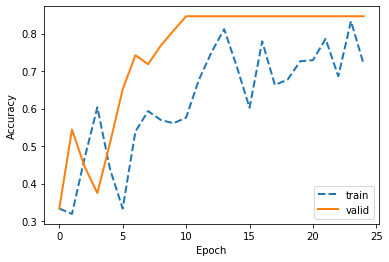

<Figure size 432x288 with 0 Axes>

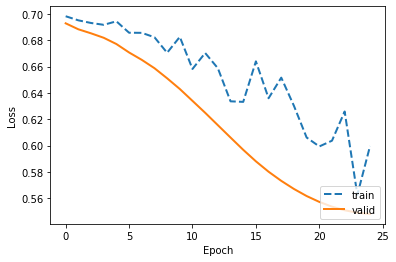

<Figure size 432x288 with 0 Axes>

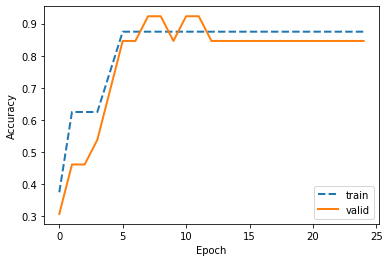

In [257]:
def train_model(dataloader, c_dataloader, v_dataloader=None, t_dataloader=None):    
    optimizer, scheduler = model.configure_optimizers()
    num_batches=len(dataloader)
    
    train_losses=[]
    train_accs=[]
    val_losses=[]
    val_accs=[]
    train_class_acc=[]
    val_class_acc=[]
    best_val=-1
    
    total_train_time=0
    
    for epoch_i in range(args.epochs):
        
        total_loss = 0
        loss_value = -1
        nb_steps=0
        nb_links=0
        step_time=0
        total_step_time=0
        current_time=0
        epoch_start=time.time()
        total_acc=0
        step_acc=0
        
        model.train()
        class_batch=next(iter(c_dataloader))
        for key,value in class_batch.items(): class_batch[key]=value.to(device)
            
        for step, batch in enumerate(dataloader):
            step_start=time.time()
            if step % args.refresh_rate == 0:            
                print(
                    'Epoch {:}/{:} Batch {:}/{:} - {:0.4f} s/it, {:0.4f} s - Elapsed: {:0.4f} s, loss_step {:0.4f}, loss_epoch {:0.4f} - train_f1_step {:0.4f}, train_f1_epoch {:0.4f}'.format(
                    epoch_i,
                    args.epochs, 
                    step,
                    num_batches,
                    step_time,
                    total_step_time,
                    time.time()-epoch_start, 
                    loss_value,
                    total_loss/max(nb_steps,1),
                    step_acc,
                    total_acc/max(nb_links,1)))
            
            batch['CVE_index'], batch['CWE_index'], batch['true_labels']=prepare_links(batch)       
            for key,value in batch.items(): batch[key]=value.to(device)
                            
            model.zero_grad()
            class_outputs=model.base_model(class_batch) #0-classlmloss, 1-classpooled
            class_lm_loss=class_outputs[0]  
            
            outputs = model(batch, class_outputs[1]) #0-loss, 1-logits, 2-true-links        
            
            loss = outputs[0].mean()            
            if class_lm_loss is not None:
                loss+= (args.lm_lambda)*class_lm_loss.mean()
            
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            
            optimizer.step() 
            scheduler.step()
            
            step_time=time.time()-step_start
            total_step_time+=step_time
            
            #stats
            loss_value = loss.item()
            total_loss+=loss_value
            logits=(torch.nn.functional.softmax(outputs[1].detach(),dim=1))
            logits= logits.cpu().numpy()
            true_links=outputs[2].detach().cpu().numpy()
            
            nb_steps+=1
            nb_links+=len(true_links)
            
            step_acc=link_f1_score(logits,true_links)
            total_acc+=step_acc*len(true_links)
            
        total_train_time+=total_step_time

        avg_train_loss=total_loss/nb_steps
        avg_train_acc=total_acc/nb_links
        
        print("Train loss: {0:.4f}".format(avg_train_loss))
        print("Train F1-Score: {0:.4f}".format(avg_train_acc))
        print("Train time: {0:.4f} sec".format(total_step_time))
        
        if args.performance_mode=='True':return
    
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        
        print("Evaluate train model")
        train_cwe_acc=LINK_evaluate_model(dataloader,c_dataloader)
        train_class_acc.append(train_cwe_acc[0])
        #print(train_cwe_acc)
        
        if v_dataloader is not None:
            print("Validation.....")        
            eval_loss, eval_accuracy=Evaluate_links(v_dataloader, c_dataloader)      
        
            print(" Average evaluation loss: {0:.4f}".format(eval_loss))
            print(" Eval F1-Score: {0:.4f}".format(eval_accuracy))
        
            val_accs.append(eval_accuracy)
            val_losses.append(eval_loss)
         
            print("Evaluate validation model")
            val_cwe_acc=LINK_evaluate_model(v_dataloader,c_dataloader)
            val_class_acc.append(val_cwe_acc[0])
            
            if args.checkpointing=='True':
                if(best_val is None or val_cwe_acc[0]>best_val):
                    best_val=val_cwe_acc[0]
                    print("Saving model....acc:",best_val)
                    torch.save(model.state_dict(), args.MODEL_DIR_FILE+'_BEST')

    print("Link Prediction Training complete!")
    
    if args.checkpointing=='True':
        print("Saving Last model")
        torch.save(model.state_dict(), args.MODEL_DIR_FILE+'_LAST')
    
    if t_dataloader is not None:    
        eval_loss, eval_accuracy=Evaluate_links(t_dataloader,c_dataloader)              
        print(" Average test loss: {0:.4f}".format(eval_loss))

        print("Evaluate test model")
        test_cwe_acc=LINK_evaluate_model(t_dataloader,c_dataloader)        
        log_results(args.MODEL_DIR_FILE+'_log.txt', {'test_accuracies':test_cwe_acc})
    
    from ipynb.fs.full.lib.Utils import save_plot
    save_plot(train_accs, val_accs, name=args.MODEL_DIR_FILE+'_link_acc',yname='Accuracy')
    save_plot(train_losses, val_losses, name=args.MODEL_DIR_FILE+'_link_loss',yname='Loss')
    save_plot(train_class_acc, val_class_acc, name=args.MODEL_DIR_FILE+'_class_acc',yname='Accuracy')
    
    log_results(args.MODEL_DIR_FILE+'_log.txt',
               {'train_accs':train_accs, 'val_accs':val_accs,
                'train_losses':train_losses, 'val_losses':val_losses,
                'train_class_acc':train_class_acc, 'val_class_acc':val_class_acc})
    
    log_results(args.MODEL_DIR_FILE+'_log.txt', {
        'total_step_time':[total_step_time],
        'num_batches':[num_batches],
        'epochs':[args.epochs],
        'batch_size':[args.batch_size]})
    
    return

if args.use_rd == 'True':
    train_model(train_dataloader, class_dataloader, val_dataloaderNC, test_dataloaderNC)
else:
    train_model(train_dataloaderNC, class_dataloaderNC, val_dataloaderNC, test_dataloaderNC)

In [258]:
def test_model(t_dataloader, c_dataloader):
    MODEL_NAME=args.MODEL_DIR_FILE+'_LAST'    

    if os.path.exists(MODEL_NAME): 
        print('Loading Saved Model: ',MODEL_NAME)        
    else: 
        print("File not found: ",MODEL_NAME)
        return
    
    print("Original weights: ");print_model_value(model)
    checkpoint = torch.load(MODEL_NAME, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint)

    print("Loaded weights: ");print_model_value(model)    
    LINK_evaluate_model(test_dataloaderNC, class_dataloaderNC)    
    
    eval_loss, eval_accuracy = Evaluate_links(test_dataloaderNC, class_dataloaderNC)
    print("Test F-1 Score: ", eval_accuracy)
    
    print("Test Complete......")
    
    return

if args.checkpointing=='True':
    test_model(test_dataloaderNC, class_dataloaderNC)        

Loading Saved Model:  ./Results/NVD/Model/CBERT-LINK-bert-base-uncased-dp_LAST
Original weights: 
link_model.module.lc_2.bias tensor([-0.0135,  0.0293], device='cuda:0', grad_fn=<SliceBackward>)
Loaded weights: 
link_model.module.lc_2.bias tensor([-0.0135,  0.0293], device='cuda:0', grad_fn=<SliceBackward>)
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0510 s
-------------------------
 Top 1,1,1... Accuracy: 0.8462
 Top 3,2,1... Accuracy: 1.0000
 Top 5,2,2... Accuracy: 1.0000
-------------------------
Batch 0/1 - 0.0000 s/it, 0.0000 s - Elapsed: 0.0727 s, loss_step -1.0000, loss_epoch 0.0000 - eval_f1_step 0.0000, eval_f1_epoch 0.0000
Test F-1 Score:  0.8461538461538461
Test Complete......


In [259]:
if __name__ == "__main__":
    None